## Initial Data Analysis of the Unmatched, Unlabelled Tweets Data

This analysis looks at trends within the sample of tweets scraped from Fortune 100 companies and associated CEO Twitter accounts +/- 3 weeks around May 25th, 2020. 

Future analyses will link Compustat data, which contain more CEO, company, and industry features.  
    

In [147]:
import sys
assert sys.version_info >= (3, 5)

import pandas as pd
import numpy as np
import datetime as dt
import os

# Import Matplotlib and Seaborn
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

##  A few useful functions and setup items
# Changing directories
def change_dir(num_steps_back, path_ext):
    """
    :param num_steps_back: how many steps back up the dir you need (1 step represented as '.', 2 steps as '..', etc.)
    :param path_ext: the desired path within project root folder (e.g., src, data)
    :return: (none)
    """
    print('Old Working Directory: ' + os.getcwd())
    os.chdir(num_steps_back)
    if not os.path.isdir(os.getcwd() + path_ext):
        os.makedirs(os.getcwd() + path_ext)
    new_dir = os.path.join(os.getcwd() + path_ext)
    os.chdir(new_dir)
    print('      ')
    print('New Working Directory: ' + os.getcwd())

    
# Saving images
def save_image(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    ch_dir('..', '/analysis/figures')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_id, format=fig_extension, dpi=resolution)
    ch_dir('...', '/notebooks')

In [148]:
# Change the directory to download the data and return to the notebooks folder.
change_dir('..', '/data')
df = pd.read_csv('tweets_df_raw.csv')
change_dir('..', '/notebooks')

Old Working Directory: /Users/pjrooney/Dropbox/Rotman/Research/_Dissertation/PoliticalStancesAndStrategy/5_Data/4_F100Tweets/Political Stance Tweets/notebooks
      
New Working Directory: /Users/pjrooney/Dropbox/Rotman/Research/_Dissertation/PoliticalStancesAndStrategy/5_Data/4_F100Tweets/Political Stance Tweets/data
Old Working Directory: /Users/pjrooney/Dropbox/Rotman/Research/_Dissertation/PoliticalStancesAndStrategy/5_Data/4_F100Tweets/Political Stance Tweets/data
      
New Working Directory: /Users/pjrooney/Dropbox/Rotman/Research/_Dissertation/PoliticalStancesAndStrategy/5_Data/4_F100Tweets/Political Stance Tweets/notebooks


In [149]:
df.head()
df = df.drop(df.columns[0], 1) # Delete the "Unnamed" column, which is a duplicate of the index

In [150]:
df.head()

,date,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,compustat_company,user_join_date,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media
0,2020-06-12T00:17:58+00:00,1271235256918487040,An important update from @SusanWojcicki on how...,86,187,1689,14,NaN,Twitter Web App,sundarpichai,ALPHABET INC,2008-03-12T05:51:53+00:00,3374827,351,1483,892,0,111
1,2020-06-11T06:37:29+00:00,1270968380304941058,Proud that @GoogleCloud is partnering with @Te...,71,417,1937,47,NaN,Twitter Web App,sundarpichai,ALPHABET INC,2008-03-12T05:51:53+00:00,3374827,351,1483,892,0,111
2,2020-06-11T05:52:43+00:00,1270957112097570816,Also excited that in #Android11 we're making i...,89,408,3016,48,NaN,Twitter Web App,sundarpichai,ALPHABET INC,2008-03-12T05:51:53+00:00,3374827,351,1483,892,0,111
3,2020-06-11T05:44:05+00:00,1270954939309645824,"Android 11 is now available in beta, with a fo...",152,709,5380,45,NaN,Twitter Web App,sundarpichai,ALPHABET INC,2008-03-12T05:51:53+00:00,3374827,351,1483,892,0,111
4,2020-05-31T14:03:32+00:00,1267094364976672768,Today on US Google &amp; YouTube homepages we ...,1736,6366,38021,700,photo,Twitter Web App,sundarpichai,ALPHABET INC,2008-03-12T05:51:53+00:00,3374827,351,1483,892,0,111


In [151]:
# Strip date and time information from original "date" feature
df['date_'] = df.date.str[:10]
df['utc_time'] = df.date.str[11:19]

In [152]:
# Convert date and time to DateTime types

In [153]:
df['date_'] = pd.to_datetime(df['date_'])
df['event_date'] = '2020-05-25'
df['event_date'] = pd.to_datetime(df['event_date'])
df['date_'].fillna(0)
df['event_date'].fillna(0)

df['utc_time'] = pd.to_datetime(df['utc_time']).dt.strftime('%H%M%S')

# Drop original date column, rename "date_" column as "date"
df = df.drop(columns=['date'])
df = df.rename(columns={'date_': 'date'})

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41530 entries, 0 to 41529
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   tweet_id           41530 non-null  int64         
 1   text               41530 non-null  object        
 2   replies            41530 non-null  int64         
 3   retweets           41530 non-null  int64         
 4   likes              41530 non-null  int64         
 5   quotes             41530 non-null  int64         
 6   media              3432 non-null   object        
 7   source_label       41530 non-null  object        
 8   username           41530 non-null  object        
 9   compustat_company  41530 non-null  object        
 10  user_join_date     41530 non-null  object        
 11  user_followers     41530 non-null  int64         
 12  user_friends       41530 non-null  int64         
 13  user_statuses      41530 non-null  int64         
 14  user_f

In [156]:
df['days_from_event'] = (df['date'] - df['event_date']).dt.days

In [157]:
df.head()

,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,compustat_company,...,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media,date,utc_time,event_date,days_from_event
0,1271235256918487040,An important update from @SusanWojcicki on how...,86,187,1689,14,NaN,Twitter Web App,sundarpichai,ALPHABET INC,...,3374827,351,1483,892,0,111,2020-06-12,001758,2020-05-25,18
1,1270968380304941058,Proud that @GoogleCloud is partnering with @Te...,71,417,1937,47,NaN,Twitter Web App,sundarpichai,ALPHABET INC,...,3374827,351,1483,892,0,111,2020-06-11,063729,2020-05-25,17
2,1270957112097570816,Also excited that in #Android11 we're making i...,89,408,3016,48,NaN,Twitter Web App,sundarpichai,ALPHABET INC,...,3374827,351,1483,892,0,111,2020-06-11,055243,2020-05-25,17
3,1270954939309645824,"Android 11 is now available in beta, with a fo...",152,709,5380,45,NaN,Twitter Web App,sundarpichai,ALPHABET INC,...,3374827,351,1483,892,0,111,2020-06-11,054405,2020-05-25,17
4,1267094364976672768,Today on US Google &amp; YouTube homepages we ...,1736,6366,38021,700,photo,Twitter Web App,sundarpichai,ALPHABET INC,...,3374827,351,1483,892,0,111,2020-05-31,140332,2020-05-25,6


In [10]:
df.describe()

,tweet_id,replies,retweets,likes,quotes,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media
count,4.153000e+04,41530.000000,41530.000000,41530.000000,41530.000000,4.153000e+04,41530.000000,4.153000e+04,41530.000000,41530.000000,41530.000000
mean,1.264048e+18,2.334313,4.212979,22.438839,0.994101,2.395559e+06,31896.905803,7.266864e+05,17249.522899,11624.849338,7075.217867
std,4.159712e+15,42.154473,66.119211,390.385367,50.894983,5.329555e+06,41729.762180,9.117064e+05,21276.001204,21365.761350,9488.712544
min,1.257098e+18,0.000000,0.000000,0.000000,0.000000,5.450000e+02,0.000000,1.390000e+02,0.000000,0.000000,24.000000
25%,1.260750e+18,0.000000,0.000000,0.000000,0.000000,2.486740e+05,292.000000,7.281900e+04,4987.000000,1688.000000,2233.000000
50%,1.263550e+18,0.000000,0.000000,0.000000,0.000000,1.082449e+06,9059.000000,1.363700e+05,5266.000000,6005.000000,2946.000000
75%,1.267451e+18,1.000000,0.000000,1.000000,0.000000,1.604150e+06,42921.000000,1.236791e+06,19915.000000,11312.000000,6855.000000
max,1.272317e+18,5112.000000,6366.000000,38021.000000,10019.000000,2.262399e+07,105727.000000,2.284221e+06,81729.000000,92837.000000,35993.000000


There are a few things worth noting from this table of summary statistics and the data generating process:

(1) There are notable outliers on many of the individual tweet-level features (e.g., replies, retweets), especially on the high end. These features have right-skewed distributions, with one (or more) accounts being prolific tweeters.

(2) The large majority of tweets in the dataset are sourced through customer experience management (CXM) platforms such as Sprinklr and Conversocial (See below). These tweets are one-on-one responses to customer inquiries. While the data only contains tweets in a 3 week window before and after May 25, 2020, the percentage of tweets that originate outside  strictly Twitter sources (e.g., Twitter Web App) could be seen as a rough proxy for the intensity of a company's interaction with individual consumers on Twitter. 

One could imagine this factor could have implications for a company's propensity to take a stance/follow-through on the stance. For example, it is reasonable to hypothesize that companies that have greater interaction with individual customers on Twitter may be more likely to be credibly pressured by these customers to take a stance on political issues on Twitter.

In [11]:
source_label = df['source_label'].value_counts()
source_label

Sprinklr                            15174
SNAP101                              9272
Lithium Tech.                        5916
Salesforce - Social Studio           3682
Conversocial                         2499
Twitter Web App                      1474
Khoros Marketing                     1203
Sprinklr Publishing                   516
Interactions Social Engage            308
Twitter for Advertisers (legacy)      236
Khoros                                235
Sprinklr Publisher                    201
Twitter for iPhone                    200
Hootsuite Inc.                        146
Clarabridge Engage                    133
Twitter Media Studio                  101
Astute Global                          45
Sprout Social                          38
Twitter Web Client                     37
Twitter Ads                            31
Twitter for iPad                       25
Percolate                              19
Liveworld Twitter Integration          18
TweetDeck                         

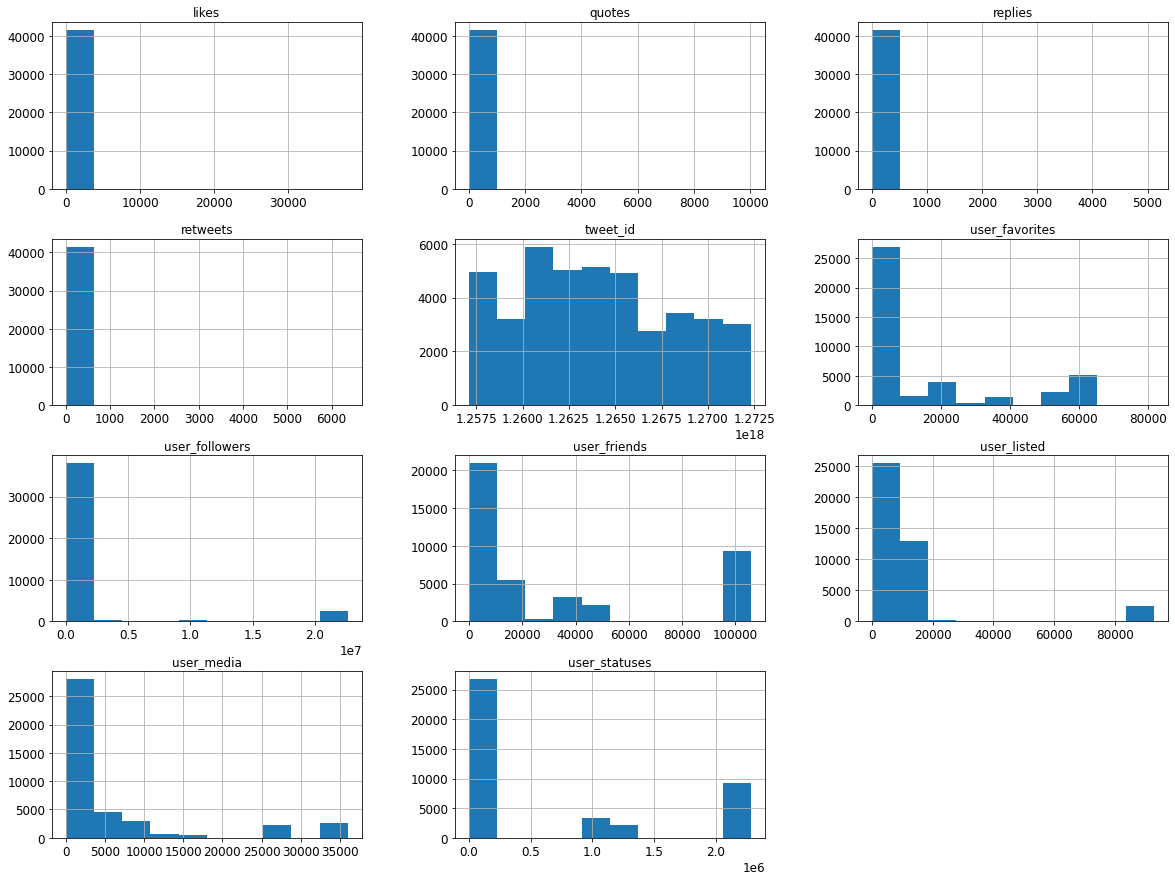

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=10, figsize=(20,15))
plt.show()

It's tough to visualize a few of these histograms (likes, quotes, replies, retweets) due to outliers at the right end of the distribution. 

As examples, looking at the value counts for the number of likes on a tweet and a histogram of tweet replies for tweets with less than 20 replies, one can see that the vast majority of tweets have zero or one likes/replies. So it appears that the data is very right skewed here. More formally, we can use scipy's skewtest, which confirms that these four  features have a larger skewness than a user's cumulative number of favorites and user's number of friends. 

In [28]:
likes_val_ct = df['likes'].value_counts()
likes_val_ct

(-38.022, 7604.2]     41512
(7604.2, 15208.4]        12
(15208.4, 22812.6]        3
(22812.6, 30416.8]        2
(30416.8, 38021.0]        1
Name: likes, dtype: int64

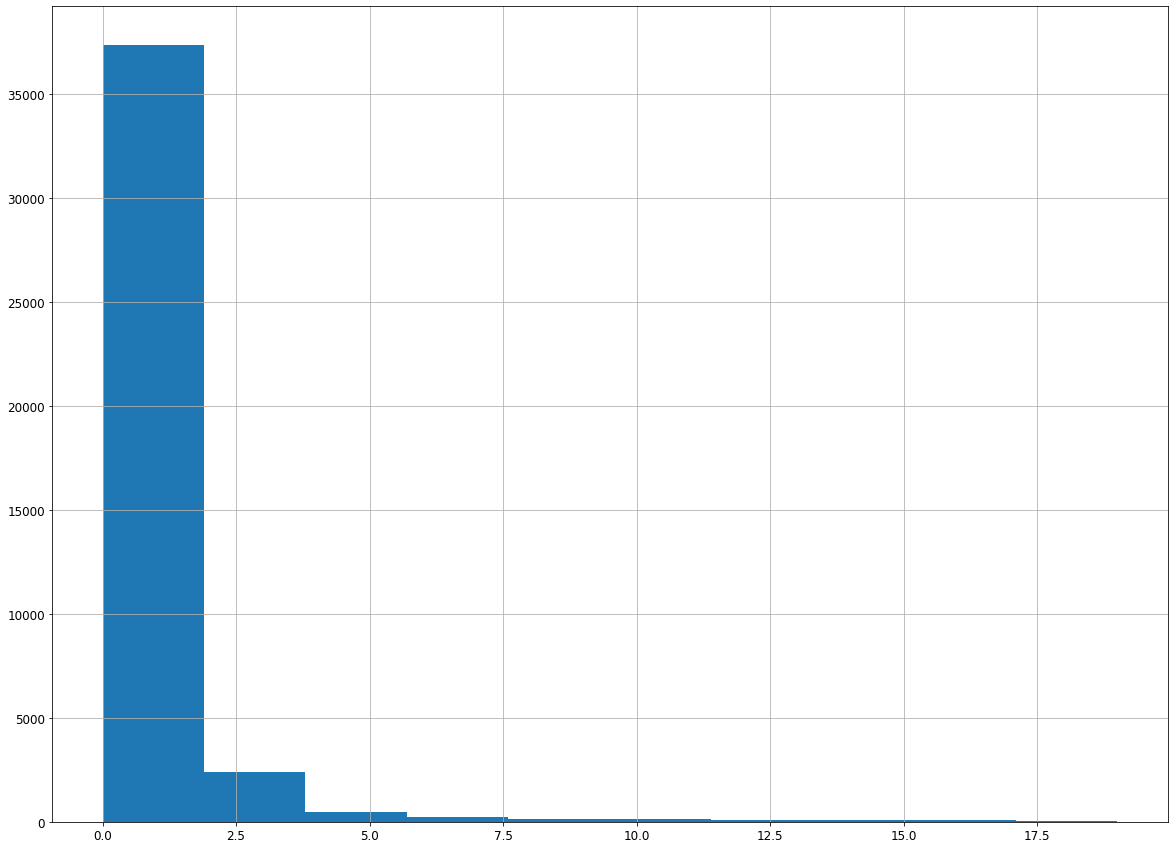

In [20]:
df_replies_cut = df[df['replies'] < 20]
df_replies_cut['replies'].hist(bins = 10, figsize=(20,15))
plt.show()

In [23]:
from scipy import stats
stats.skewtest(df[['likes', 'quotes', 'replies', 'retweets', 'user_favorites', 'user_friends']])

SkewtestResult(statistic=array([329.99025802, 415.47148641, 353.46747231, 329.52727879,
        87.73951864,  72.09190793]), pvalue=array([0., 0., 0., 0., 0., 0.]))

At this point, there are a few potentially interesting next steps:

1. What tweets are in the right tail of the likes and retweets? These tweets are ostensibly the ones with the most "reach" on Twitter.

2. How do these descriptives change when we remove non-Twitter sources?

Let's start with looking at the text and distribution in time, say of the 30 tweets with the most likes. 

Below, we see that a reasonable, round-number cutoff for this descriptive analysis would be likes > 5000

In [174]:
likes_val_ct = df['likes'].value_counts(bins=10)
likes_val_ct

(-38.022, 3802.1]     41493
(3802.1, 7604.2]         19
(7604.2, 11406.3]        11
(19010.5, 22812.6]        3
(34218.9, 38021.0]        1
(26614.7, 30416.8]        1
(22812.6, 26614.7]        1
(11406.3, 15208.4]        1
(30416.8, 34218.9]        0
(15208.4, 19010.5]        0
Name: likes, dtype: int64

Let's now look at the days from the shooting (where negative days indicates days prior to May 25) and the associated text of these tweets.

Although the output contains surface level descriptives, one can already see strong representation of words that are associated with taking a stance on the event (e.g., "Minneapolis", "race", "using our platform"). This warrants a more rigorous text analysis with the data.

In [175]:
df_indiv_tweets = df[['date','days_from_event', 'text', 'replies', 'retweets', 'likes', 'quotes']]
print(df_indiv_tweets[['days_from_event','text']][df_indiv_tweets['likes']>5000])

       days_from_event                                               text
3                   17  Android 11 is now available in beta, with a fo...
4                    6  Today on US Google &amp; YouTube homepages we ...
9                   -5  The #COVID19 Exposure Notification technology ...
11                 -13  We've re-engineered Google Meet to make secure...
18                  17  The unfinished work of racial justice and equa...
19                  10  Today, as Minneapolis gathers and the nation m...
20                   4  Minneapolis is grieving for a reason. To parap...
22                   0  We will never forget the memory and sacrifice ...
23                  -2  Wishing safety, happiness and peace to those c...
26                  -5  Technology can help health officials rapidly t...
28                 -13  To the nurses who work every day to save the l...
29                 -15  The dreams mothers nurture become the ideas th...
31                 -20  Every year I a

We can also take a quick look at the distributions of this subsample of highly liked tweets compared to the full sample. 

Compared to the full sample, the sample of most liked tweets has a notable center of mass just right of the event date. Coupled with the cursory analysis above, it appears that political stance tweets may attract significant attention relative to the average corporate tweet.

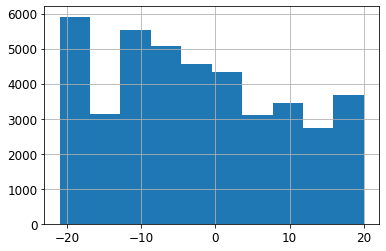

In [176]:
df['days_from_event'].hist(bins=10)
plt.show()

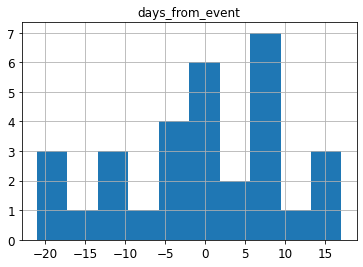

In [169]:
df_indiv_tweets[['days_from_event']][df_indiv_tweets['likes'] > 5000].hist(bins=10)
plt.show()